In [129]:
# %reload_ext autoreload
# %autoreload 2

import os
import sys

root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd
import logging

import mne
import numpy as np
import pandas as pd

log = lambda msg: logging.info(msg)




# TODO
Try minsSinceLEP - though this also gives away timing

# Load data

In [130]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [131]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df = stitch_pipeline_results.stitch_all_days_optimised(input_dir, should_remove_days_per_questionnaire=False)

  0%|          | 0/160 [00:00<?, ?it/s]

c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (590) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (590) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_

In [132]:
df['dayAndNightOf'].unique()

<DatetimeArray>
['2024-07-08 00:00:00', '2024-07-11 00:00:00', '2024-07-12 00:00:00',
 '2024-07-13 00:00:00', '2024-07-14 00:00:00', '2024-07-15 00:00:00',
 '2024-07-16 00:00:00', '2024-07-17 00:00:00', '2024-07-21 00:00:00',
 '2024-07-22 00:00:00',
 ...
 '2025-02-17 00:00:00', '2025-02-18 00:00:00', '2025-02-19 00:00:00',
 '2025-02-20 00:00:00', '2025-02-23 00:00:00', '2025-02-24 00:00:00',
 '2025-02-26 00:00:00', '2025-02-27 00:00:00', '2025-03-01 00:00:00',
 '2025-03-05 00:00:00']
Length: 140, dtype: datetime64[ns]

# Prepare data

In [163]:

import sys
from importlib import reload
import models.util.epoch_level_features
reload(models.util.epoch_level_features)
import time_to_sleep_model
reload(time_to_sleep_model)

models_and_data = time_to_sleep_model.create_and_add_all(df, False)

from sklearn.model_selection import train_test_split

unique_days = df['dayAndNightOf'].unique()
# Take a random 10% of the days for testing
test_days, train_days = train_test_split(unique_days, test_size=0.9, random_state=42)

print(f"Training on {len(train_days)} days, testing on {len(test_days)} days")

def split(modelAndData: time_to_sleep_model.ModelAndData):
    temp_X = modelAndData.X.copy()
    temp_y = modelAndData.y.copy()
    temp_X['dayAndNightOf'] = df['dayAndNightOf']

    train_mask = temp_X['dayAndNightOf'].isin(train_days)
    test_mask = temp_X['dayAndNightOf'].isin(test_days)

    temp_X.drop(columns=['dayAndNightOf'], inplace=True)

    modelAndData.X_train = temp_X[train_mask]
    modelAndData.y_train = temp_y[train_mask]
    modelAndData.X_val = temp_X[test_mask]
    modelAndData.y_val = temp_y[test_mask]

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 141), first index 0, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (15494, 141) to (15494, 141), first index 0
DropBadRows (15494, 141) to (15494, 141), first index 0
CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 132), first index 0, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (15494, 132) to (15494, 132), first index 0
DropBadRows (15494, 132) to (15494, 132), first index 0
CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 128), fir

# Train models

In [164]:
import models.util.importances as importances
reload(importances)

import models.util.rfe_training as training
reload(training)
import copy

import memory

memory.garbage_collect(print)

train_list = []
# train_list.append({"type": "XGBoost+HSTreeClassifierCV", "requireRemovedNan": True})
# train_list.append({"type": "ExplainableBoostingClassifier"})
# train_list.append({"type": "ExplainableBoostingRegressor"})
# train_list.append({"type": "FIGSRegressor", "rfe": False, "requireRemovedNan": True})
train_list.append({"type": "XGBoost", "rfe": True, "supportsFeatureWeights": True})



for md in models_and_data:
    models = []
    for tl in train_list:
        if tl.get('requireRemovedNan', False) and not md.removed_nan:
            continue

        tl_copy = copy.deepcopy(tl)
        if (tl['type'] == 'XGBoost'):
            tl_copy['type'] = 'XGBoostClassifier' if md.is_classifier else 'XGBoostRegressor'
        if (tl['type'] == 'XGBoost+HSTreeClassifierCV'):
            tl_copy['type'] = 'XGBoostClassifier+HSTreeClassifierCV' if md.is_classifier else 'XGBoostRegressor+HSTreeRegressor'

        rfe = tl.get('rfe', False)
        models.extend(training.train_rfe(training.get_model, tl_copy, md.name, md.X_train, md.y_train, md.X_val, md.y_val, rfe))
    md.models = models

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))


Memory Usage: 2214.21 MB GC to 2214.21 MB
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 140)... RMSE train: 1.2604221327060714 RMSE val: 15.908287883350027
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 70)... RMSE train: 1.4219537334564414 RMSE val: 16.389607080403625
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 35)... RMSE train: 1.5660696258958293 RMSE val: 15.848717979586915
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 17)... RMSE train: 2.2916601796992966 RMSE val: 16.48165997236754
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 8)... RMSE train: 3.366297771787529 RMSE val: 17.340721520990463
Training XGBoostRegressor model for minsSinceReadyToSleep_AllEeg+Physical_1HrBefore with (13908, 4)... RMSE train: 6.416137816572883 RMSE va

,MAE_Train,MAE_Val,RMSE_Train,RMSE_Val,Rows_Train,Model,MdIdx,MsIdx,n_features,source,isClassifier
0,0.882546,13.250682,1.260422,15.908288,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,0,140,XGBoostRegressor,False
1,0.991247,13.356014,1.421954,16.389607,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,1,70,XGBoostRegressor,False
2,1.071583,12.855076,1.566070,15.848718,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,2,35,XGBoostRegressor,False
3,1.536168,13.226378,2.291660,16.481660,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,3,17,XGBoostRegressor,False
4,2.240656,13.903899,3.366298,17.340722,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,4,8,XGBoostRegressor,False
5,4.514248,14.036915,6.416138,17.121787,13908,minsSinceReadyToSleep_AllEeg+Physical_1HrBefore,0,5,4,XGBoostRegressor,False
6,1.064590,13.014343,1.531371,15.799940,13908,minsSinceReadyToSleep_BestEeg+Physical_1HrBefore,1,0,131,XGBoostRegressor,False
7,1.046770,13.036904,1.513198,15.867503,13908,minsSinceReadyToSleep_BestEeg+Physical_1HrBefore,1,1,65,XGBoostRegressor,False
8,1.250566,13.175620,1.831068,16.135777,13908,minsSinceReadyToSleep_BestEeg+Physical_1HrBefore,1,2,32,XGBoostRegressor,False
9,1.596710,13.371117,2.367506,16.584133,13908,minsSinceReadyToSleep_BestEeg+Physical_1HrBefore,1,3,16,XGBoostRegressor,False


c:\dev\Brainwave-Processor\models\util\evaluation.py:266: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  


""


In [136]:
bm = models_and_data[2].models[4]

# Evaluate the model

Evaluation for model:  minsSinceReadyToSleep_BestEeg_1HrBefore
minsSinceReadyToSleep_BestEeg_1HrBefore Training Set Evaluation:
MAE: 2.663456619905919, MSE: 14.907292575017784, RMSE: 3.8609963189593675
minsSinceReadyToSleep_BestEeg_1HrBefore Validation Set Evaluation:
MAE: 6.413928646697825, MSE: 75.38635118223333, RMSE: 8.68253138101057


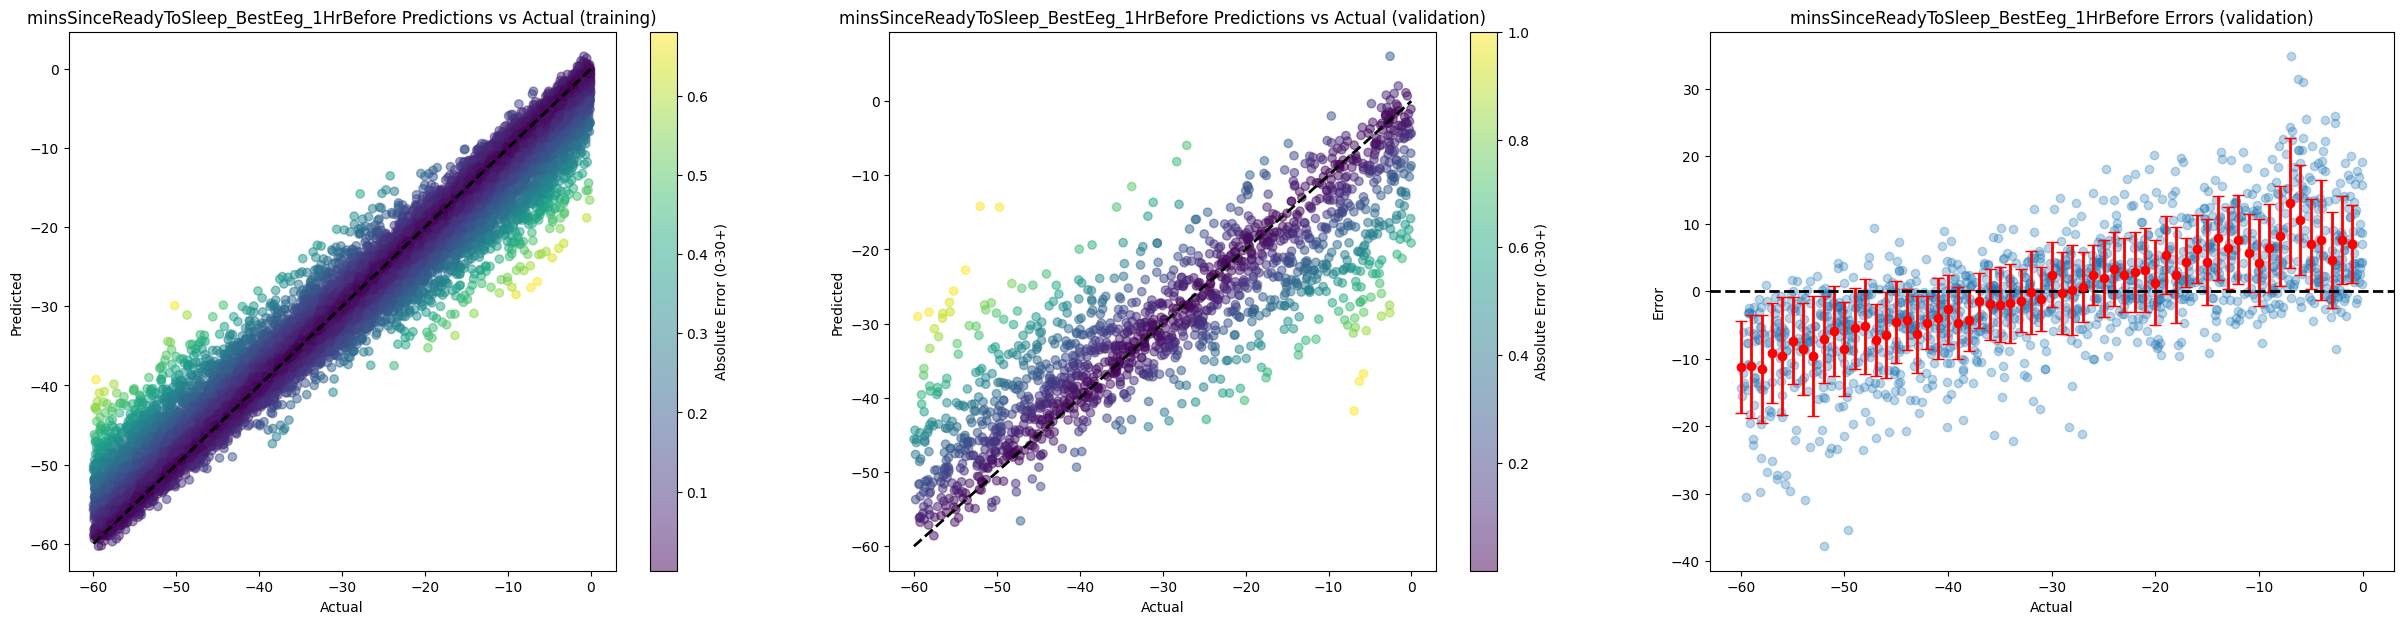

In [137]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_model(bm.model, bm.name, bm.X_train, bm.y_train, bm.X_val, bm.y_val, bm.is_classifier)


 # Save model


In [138]:
%%capture
filenames = []

try:
    os.mkdir("models")
except:
    pass

for md in models_and_data:
    for ms in md.models:
        model_filename = f"models/{'cls' if md.is_classifier else 'reg'}_{md.name}_rfe{len(ms.X_train.columns)}_xgboost_model.cbm"
        log(f"Saving model {md} to {model_filename}")
        ms.model.save_model(model_filename)
        filenames.append(model_filename)


In [139]:
for fn in filenames:
    print(f"\"{fn}\",")

"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe140_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe70_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe35_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe17_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe8_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_AllEeg+Physical_1HrBefore_rfe4_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physical_1HrBefore_rfe131_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physical_1HrBefore_rfe65_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physical_1HrBefore_rfe32_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physical_1HrBefore_rfe16_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physical_1HrBefore_rfe12_xgboost_model.cbm",
"models/reg_minsSinceReadyToSleep_BestEeg+Physica

# Most useful features

In [140]:
%%capture

import shap
import xgboost as xgb


explainer = shap.Explainer(bm.model)
shap_values = explainer(bm.X_train)

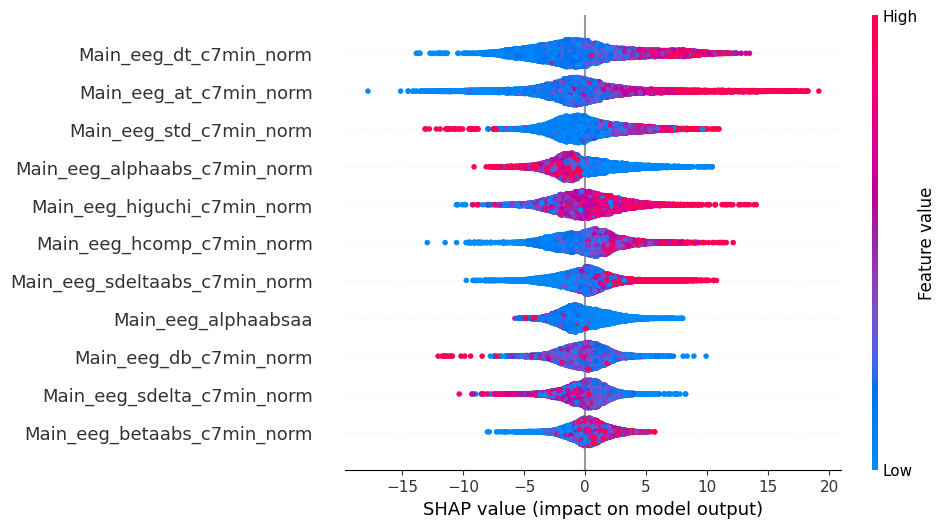

In [141]:
shap.plots.beeswarm(shap_values, max_display=20)


In [142]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 featur~es
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

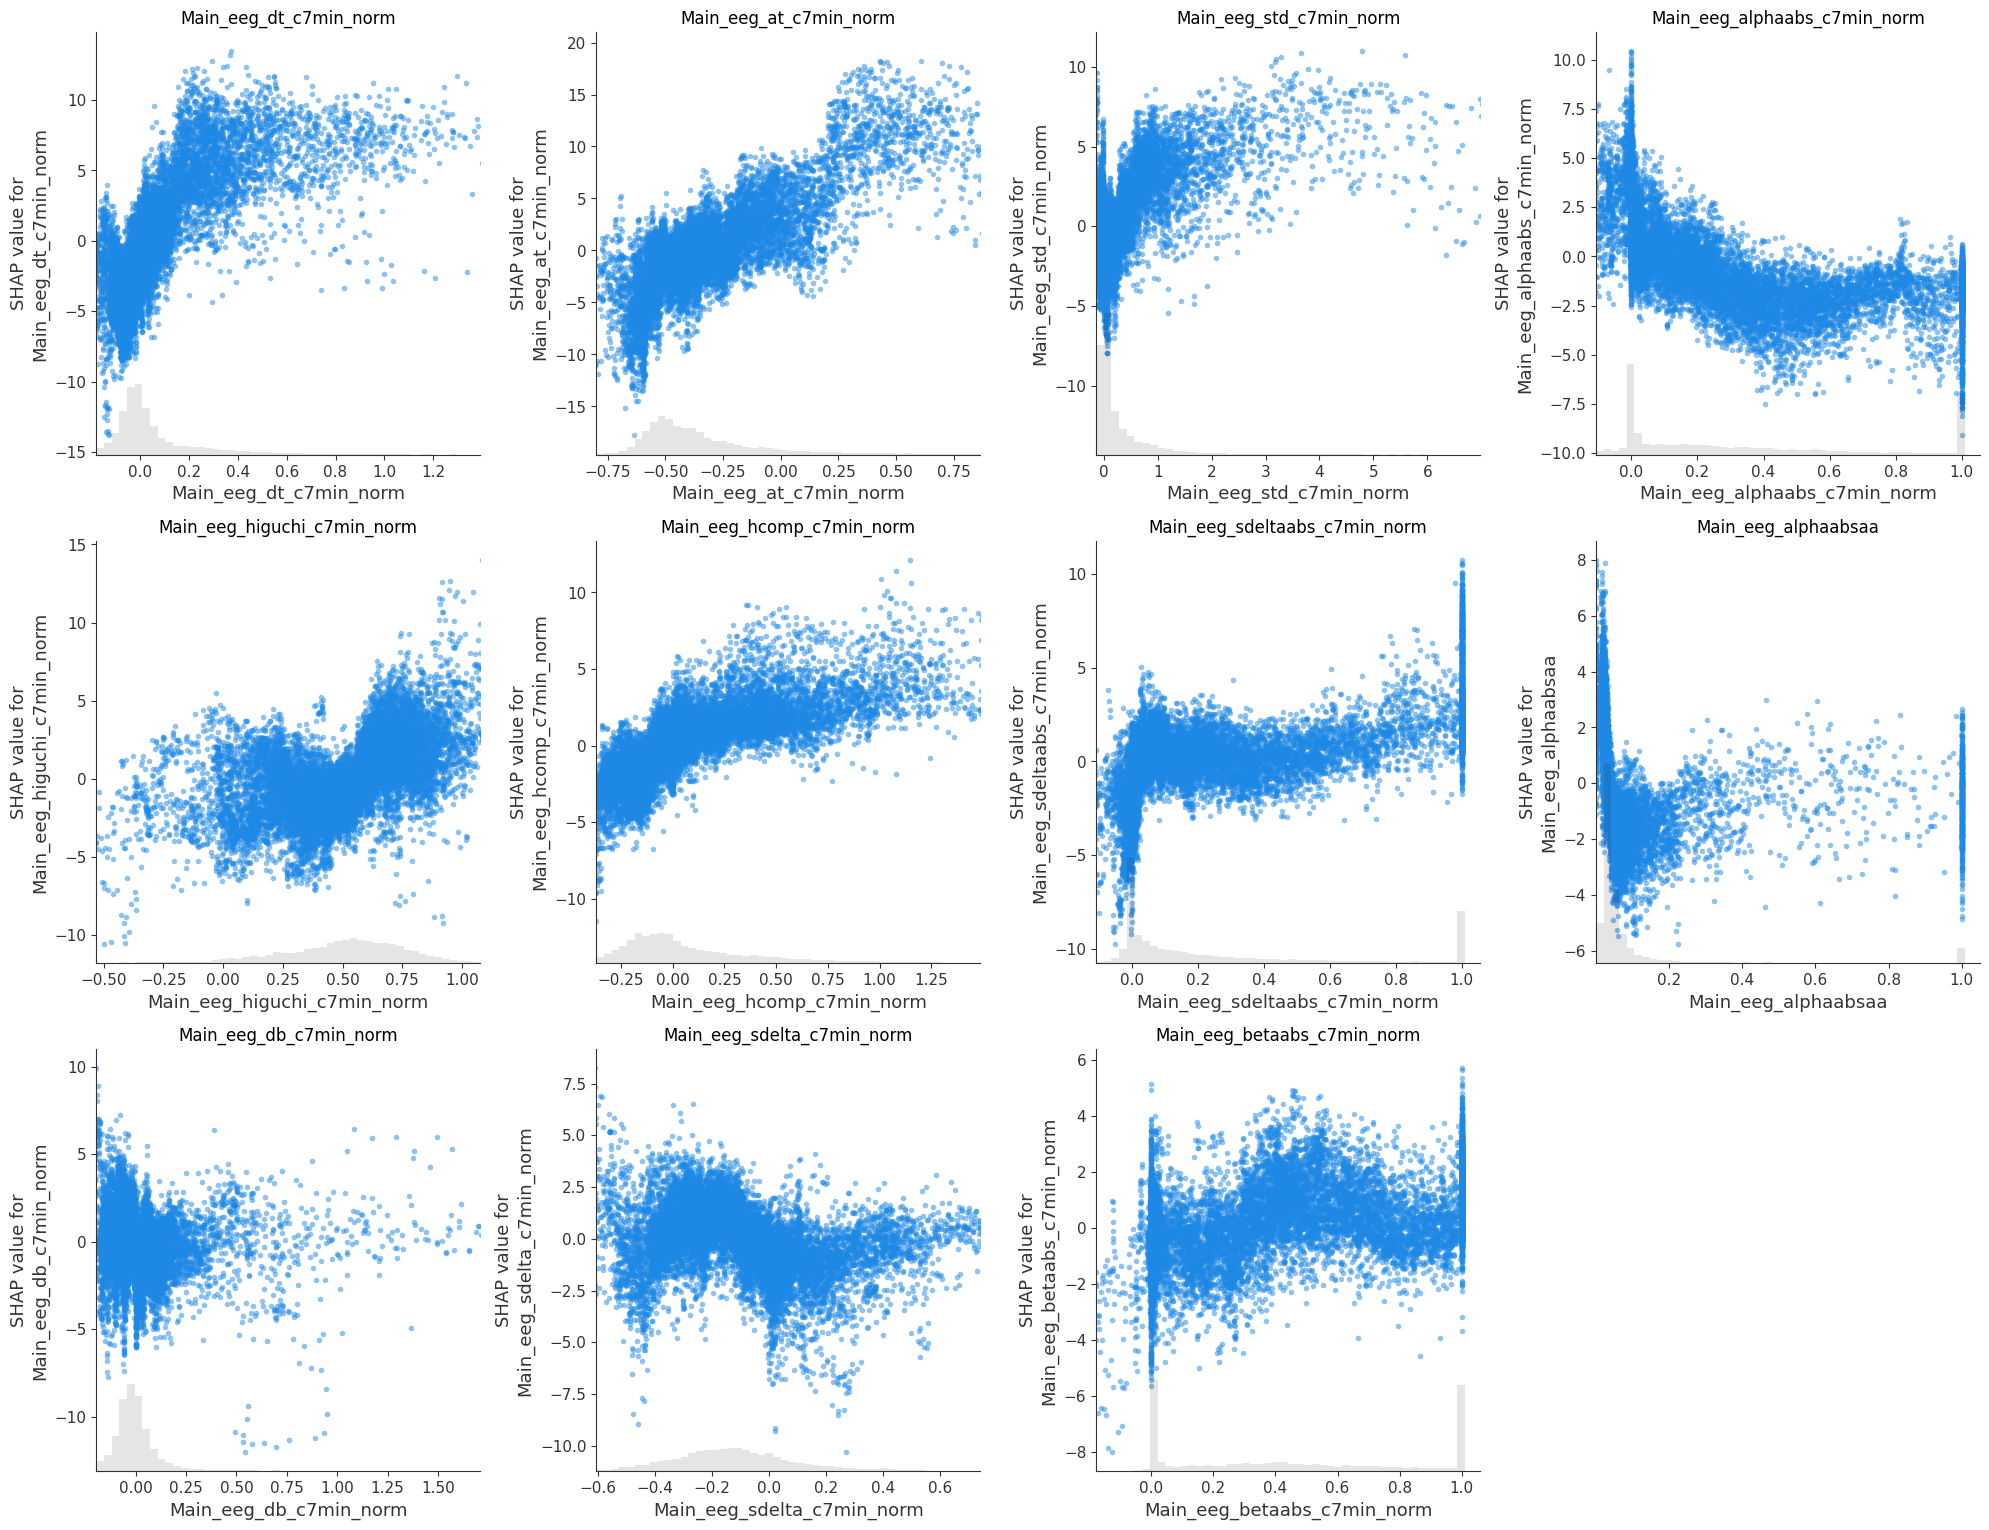

In [143]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Prediction errors across nights

In [150]:
import sleep_events
from importlib import reload

reload(sleep_events)

from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [145]:
all_days_models_and_data = time_to_sleep_model.create_and_add_all(df, True)
all_days_X = all_days_models_and_data[2].X[bm.X_train.columns]
all_days_predictions = bm.model.predict(all_days_X)
all_days_predictions_df = pd.DataFrame(all_days_predictions, columns=['Prediction'], index=all_days_X.index)
all_days_df_with_pred = df.join(all_days_predictions_df)
all_days_df_with_pred['Error'] = all_days_df_with_pred['minsSinceReadyToSleep'] - all_days_df_with_pred['Prediction']



CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 141), first index 0, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (15494, 141) to (15494, 141), first index 0
DropBadRows (15494, 141) to (15494, 141), first index 0
CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 132), first index 0, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (15494, 132) to (15494, 132), first index 0
DropBadRows (15494, 132) to (15494, 132), first index 0
CleanTargetCol (155623, 348) to (154626, 348)
Condition (154626, 348) to (15494, 348), first index 0
ClipAbsOutliers (15494, 45) to (15494, 45), first index 0
EpochLevelFeaturesHandler (15494, 348) to (15494, 127), fir

In [146]:
[col for col in all_days_df_with_pred.columns if 'ready' in col.lower()]

['15MinsBeforeReadyToSleep',
 '30MinsBeforeReadyToSleep',
 '60MinsBeforeReadyToSleep',
 'DuringReadyToSleep',
 'minsSinceReadyToSleep',
 'SSPreReadyToSleep',
 'SSDuringReadyToSleep']

In [147]:
all_days_df_with_pred['minsSinceReadyToSleep']

0         -44.720607
1         -44.220607
2         -43.720607
3         -43.220607
4         -42.720607
             ...    
155618    478.670945
155619    479.170945
155620    479.670945
155621    480.170945
155622    480.670945
Name: minsSinceReadyToSleep, Length: 155623, dtype: float64

In [152]:
[col for col in days_data if 'ready' in col]

['night:nightEvents:readyToSleepTimeSSM',
 'night:fitbit:source:readyToSleepTimeSSM',
 'night:fitbit:adjusted:readyToSleepTimeSSM',
 'night:aggregated:readyToSleepTimeSSM',
 'night:morningQuestionnaire:disturbances:Note-taking woke me:readying',
 'night:morningQuestionnaire:disturbances:Horny:readying',
 'night:morningQuestionnaire:disturbances:Too cold:readying',
 'night:morningQuestionnaire:disturbances:Pee (definitely woke me):readying',
 'night:morningQuestionnaire:disturbances:Too warm:readying',
 'night:morningQuestionnaire:disturbances:Tensed shoulders:readying',
 'night:morningQuestionnaire:disturbances:Thinking about work:readying',
 'night:morningQuestionnaire:disturbances:Whirling thoughts:readying',
 'night:morningQuestionnaire:disturbances:Pee (not sure if woke me):readying',
 'night:morningQuestionnaire:disturbances:Other:readying',
 'night:morningQuestionnaire:disturbances:Cat:readying',
 'night:yasa:adjusted:readyToSleepTimeSSM',
 'night:morningQuestionnaire:disturbance

In [153]:
import pandas as pd

grouped_df = all_days_df_with_pred.groupby('dayAndNightOf').agg(
    MAE=('Error', lambda x: x.abs().mean()),
    MinMinsUntilReadyToSleep=('minsSinceReadyToSleep', lambda x: x.min()),
    ReadyToSleep=('dayAndNightOf', lambda x: days_data[days_data['dayAndNightOf'] == x.iloc[0]]['readyToSleepTime'].iloc[0] if len(days_data[days_data['dayAndNightOf'] == x.iloc[0]]) > 0 else None),
).reset_index()
grouped_df

,dayAndNightOf,MAE,MinMinsUntilReadyToSleep,ReadyToSleep
0,2024-07-08,1.559202,-44.720607,2024-07-08 23:36:00+01:00
1,2024-07-11,3.516139,-25.192282,2024-07-11 23:11:30+01:00
2,2024-07-12,1.918070,-50.025857,2024-07-12 23:29:00+01:00
3,2024-07-13,2.533852,-66.069598,2024-07-13 22:48:00+01:00
4,2024-07-14,2.041898,-26.562526,2024-07-14 22:54:00+01:00
...,...,...,...,...
135,2025-02-24,2.874345,-99.786251,2025-02-24 23:40:26+00:00
136,2025-02-26,1.998709,-72.742890,2025-02-26 22:33:46+00:00
137,2025-02-27,2.149570,-65.206451,2025-02-27 22:28:00+00:00
138,2025-03-01,2.451481,-66.416284,2025-03-01 22:53:20+00:00


In [110]:
grouped_df[grouped_df['MAE'] <= 3]

,dayAndNightOf,MAE,MinMinsUntilReadyToSleep
1,2024-07-11,1.354016,-25.192282
2,2024-07-12,1.358637,-50.025857
5,2024-07-15,0.993300,-26.500554
6,2024-07-16,1.036367,-44.130836
7,2024-07-17,1.847978,-27.175546
...,...,...,...
114,2025-01-23,1.358356,-103.753209
115,2025-01-27,1.702944,-109.145052
116,2025-01-28,1.590758,-97.765303
117,2025-01-30,2.263202,-80.389637


# Looking at specific nights

CleanTargetCol (1141, 348) to (1141, 348)
Condition (1141, 348) to (104, 348), first index 98680
ClipAbsOutliers (104, 45) to (104, 45), first index 98680
EpochLevelFeaturesHandler (104, 348) to (104, 141), first index 98680, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (104, 141) to (104, 141), first index 98680
DropBadRows (104, 141) to (104, 141), first index 98680
CleanTargetCol (1141, 348) to (1141, 348)
Condition (1141, 348) to (104, 348), first index 98680
ClipAbsOutliers (104, 45) to (104, 45), first index 98680
EpochLevelFeaturesHandler (104, 348) to (104, 132), first index 98680, applied ClipOutliers to 45 'abs' columns
RequireNonEmptyRows (104, 132) to (104, 132), first index 98680
DropBadRows (104, 132) to (104, 132), first index 98680
CleanTargetCol (1141, 348) to (1141, 348)
Condition (1141, 348) to (104, 348), first index 98680
ClipAbsOutliers (104, 45) to (104, 45), first index 98680
EpochLevelFeaturesHandler (104, 348) to (104, 127), first index 98680, 

C:\Users\graha\AppData\Local\Temp\ipykernel_37020\134497918.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_df['minsSinceReadyToSleep'] = interesting_df['minsSinceReadyToSleep']


2.911453247834492

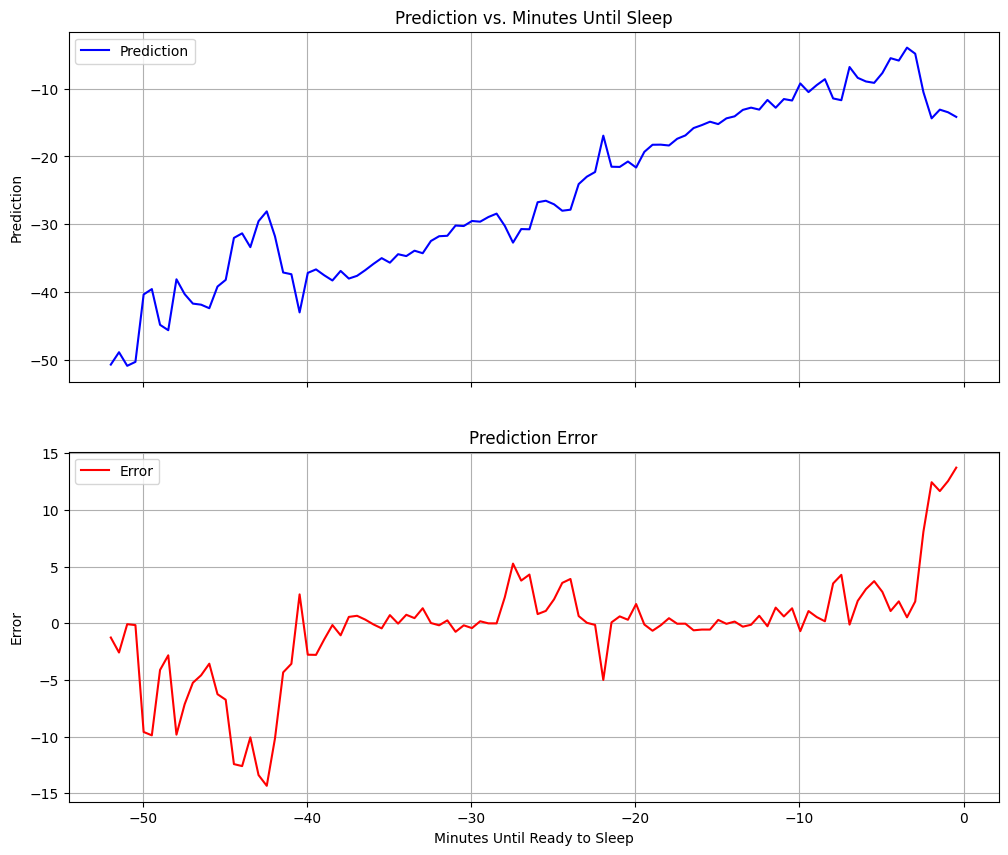

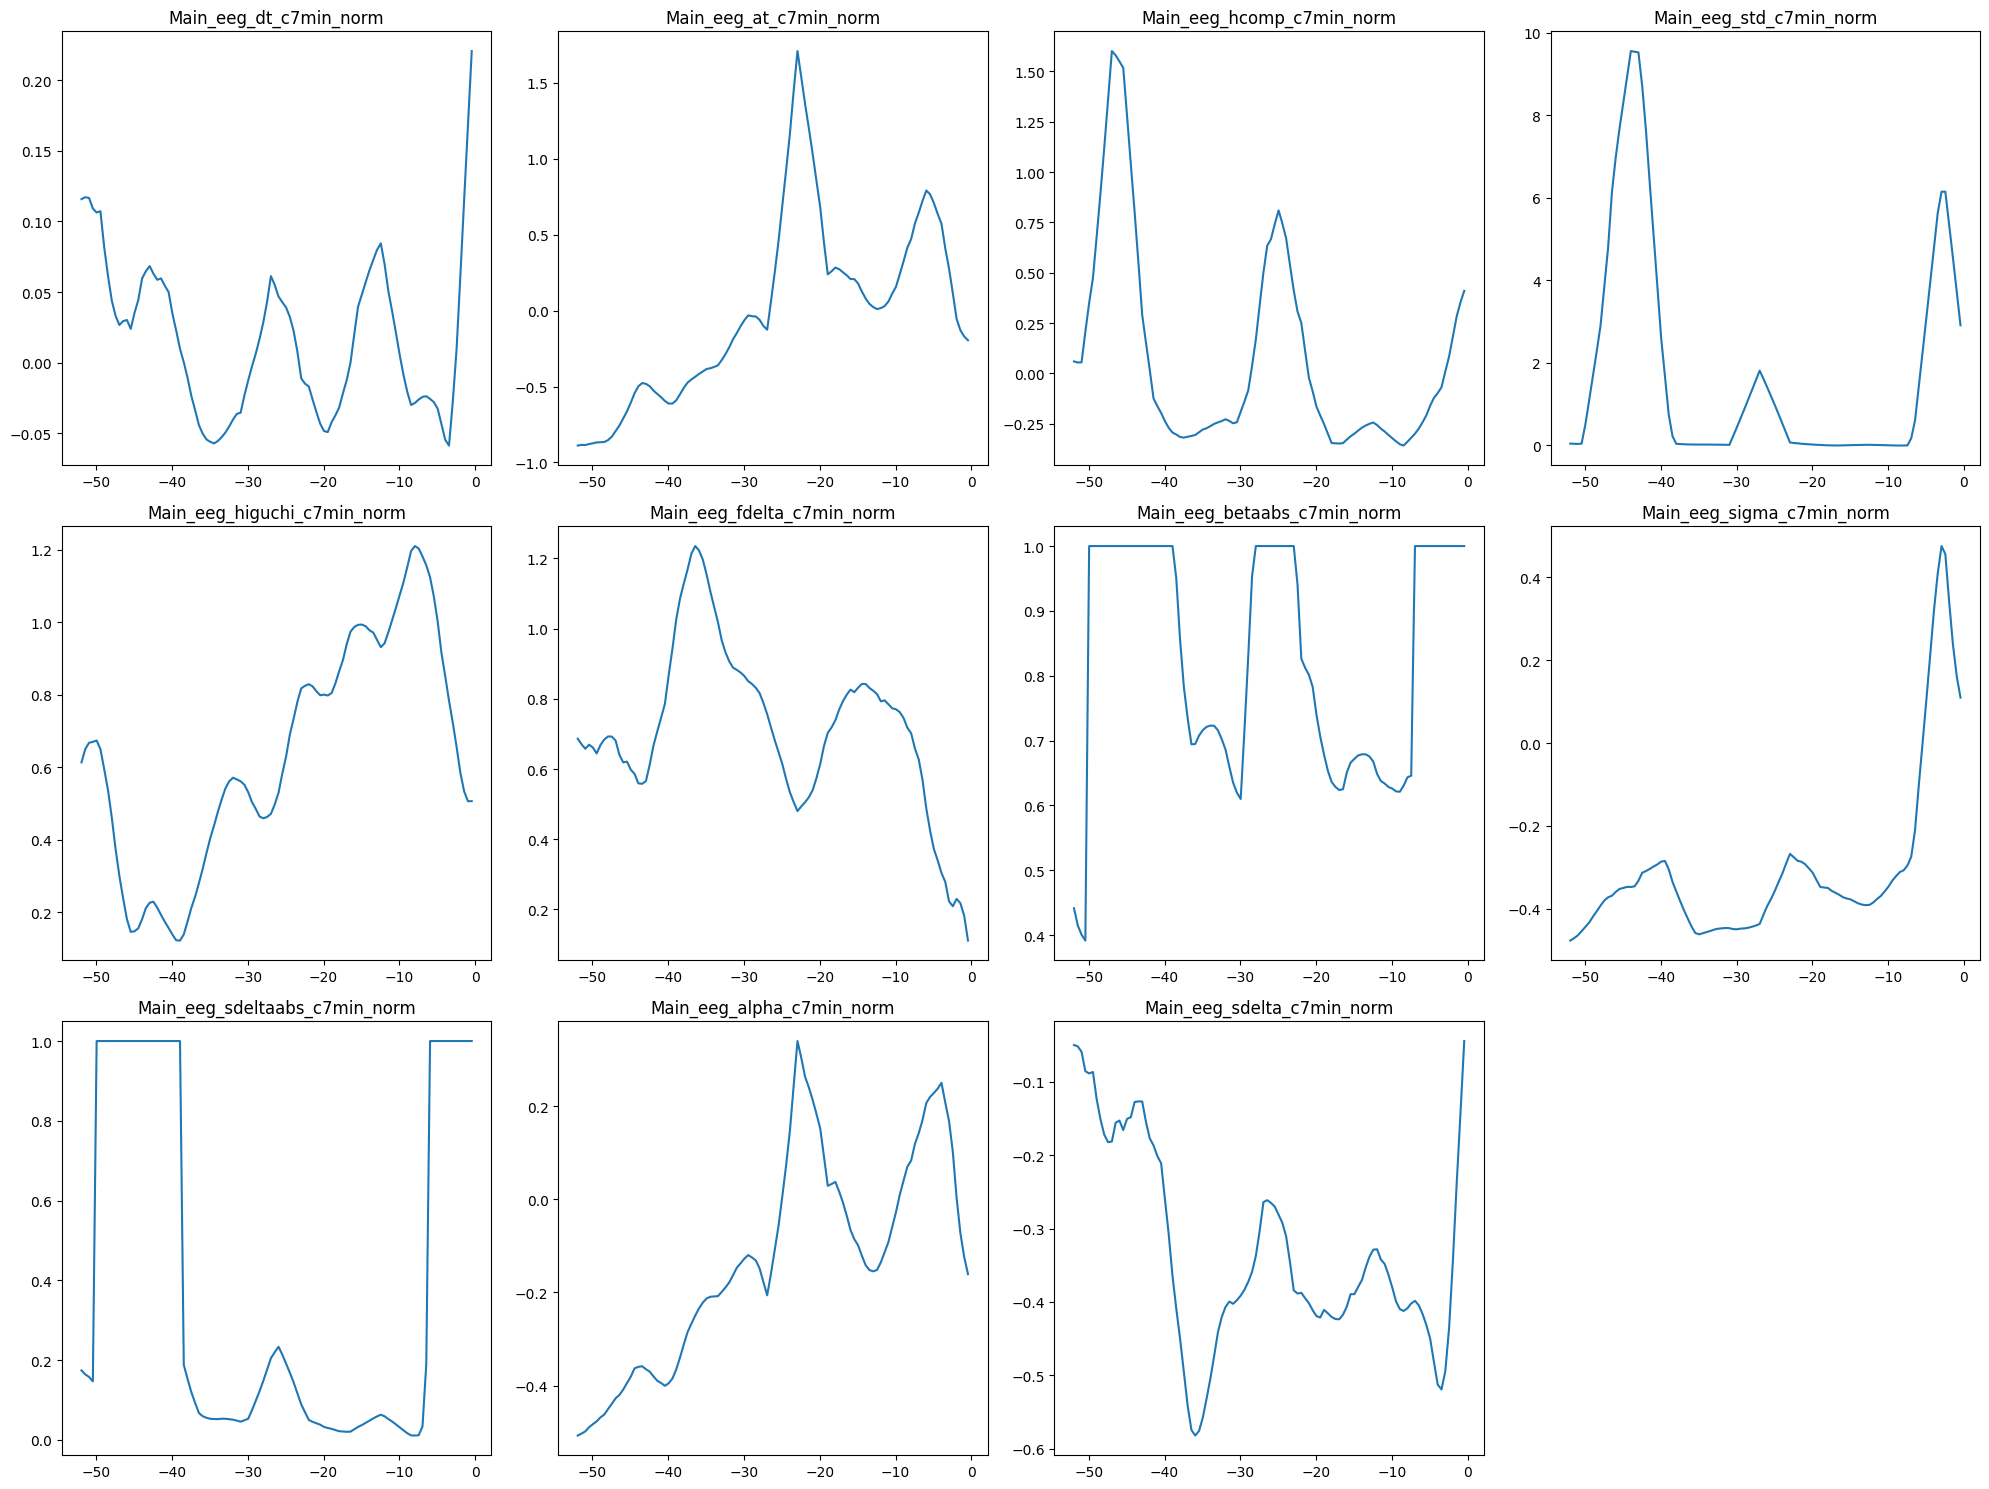

(      Stage  Confidence  Epoch                           Timestamp  Source  \
 98680     W    1.000000      0 2024-12-16 21:26:57.269495964+00:00  Fpz-M1   
 98681     W    0.996490      1 2024-12-16 21:27:27.269495964+00:00  Fpz-M1   
 98682     W    0.997820      2 2024-12-16 21:27:57.269495964+00:00  Fpz-M1   
 98683     W    0.995800      3 2024-12-16 21:28:27.269495964+00:00  Fpz-M1   
 98684     W    0.999831      4 2024-12-16 21:28:57.269495964+00:00  Fpz-M1   
 ...     ...         ...    ...                                 ...     ...   
 99816     W    0.944483   1136 2024-12-17 06:54:57.269495964+00:00  Fpz-M1   
 99817     W    0.950566   1137 2024-12-17 06:55:27.269495964+00:00  Fpz-M1   
 99818     W    0.990532   1138 2024-12-17 06:55:57.269495964+00:00  Fpz-M1   
 99819     W    0.987557   1139 2024-12-17 06:56:27.269495964+00:00  Fpz-M1   
 99820     W    0.995162   1140 2024-12-17 06:56:57.269495964+00:00  Fpz-M1   
 
        StageInt  Main_eeg_abspow  Main_eeg_abspow

In [128]:
import matplotlib.pyplot as plt
import math
import models.util.pipeline
reload(models.util.pipeline)
import models.util.epoch_level_features
reload(models.util.epoch_level_features)
import time_to_sleep_model
reload(time_to_sleep_model)

def plot_features(df):
    df = df.copy()
    features = bm.X_train.columns

    # Calculate grid dimensions
    n_features = len(features)
    n_cols = 4  # 4 plots across
    n_rows = math.ceil(n_features / n_cols)

    # Create figure with appropriate size
    fig_width = 20  # inches
    fig_height = 5 * n_rows  # 5 inches per row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Create plots for each feature
    for i, feature in enumerate(features):
        if i < len(axes):  # Safety check
            ax = axes[i]
            
            # Plot the feature for the selected day
            #df['time_of_day'] = pd.to_datetime(df.index).time
            ax.plot(df['minsSinceReadyToSleep'], df[feature])
            
            # Set title and labels
            ax.set_title(feature)
            
            # Format x-axis to show time nicely
            #ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
            #plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_day(day: str):
    interesting_df = df[df['dayAndNightOf'] == day]
    interesting_df.head()
    interesting_day_models_and_data = time_to_sleep_model.create_and_add_all(interesting_df, True)

    prepared_df = interesting_day_models_and_data[2].prepared_df[bm.X_train.columns]
    X = interesting_day_models_and_data[2].X[bm.X_train.columns]
    interesting_day_predictions = bm.model.predict(X)

    prepared_df['minsSinceReadyToSleep'] = interesting_df['minsSinceReadyToSleep']
    interesting_day_predictions_df = pd.DataFrame(interesting_day_predictions, 
                                                columns=['Prediction'],
                                                index=X.index)
    interesting_df_with_pred = interesting_df.join(interesting_day_predictions_df)
    
    interesting_df_with_pred['Error'] = interesting_df_with_pred['minsSinceReadyToSleep'] - interesting_df_with_pred['Prediction']
    mae = interesting_df_with_pred['Error'].abs().mean()
    display(mae)
    interesting_df_with_pred[['minsSinceAsleep', 'Prediction', 'Error']]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot predictions on the first subplot
    ax1.plot(interesting_df_with_pred['minsSinceReadyToSleep'], interesting_df_with_pred['Prediction'], 'b-', label="Prediction")
    ax1.set_ylabel("Prediction")
    ax1.set_title("Prediction vs. Minutes Until Sleep")
    ax1.legend()
    ax1.grid(True)

    # Plot error on the second subplot if error was calculated
    if 'Error' in interesting_df_with_pred.columns:
        ax2.plot(interesting_df_with_pred['minsSinceReadyToSleep'], interesting_df_with_pred['Error'], 'r-', label="Error")
        ax2.set_xlabel("Minutes Until Ready to Sleep")
        ax2.set_ylabel("Error")
        ax2.set_title("Prediction Error")
        ax2.legend()
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, "Error cannot be calculated - no actual values available", 
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

    # plt.tight_layout()
    # plt.show()

    plot_features(prepared_df)

    return interesting_df_with_pred, mae

plot_day("2024-12-16")

# Some old analysis that doesn't work anymore

In [30]:
shap.dependence_plot(0, shap_values, modelsAndData[0].X_train)

NameError: name 'modelsAndData' is not defined

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

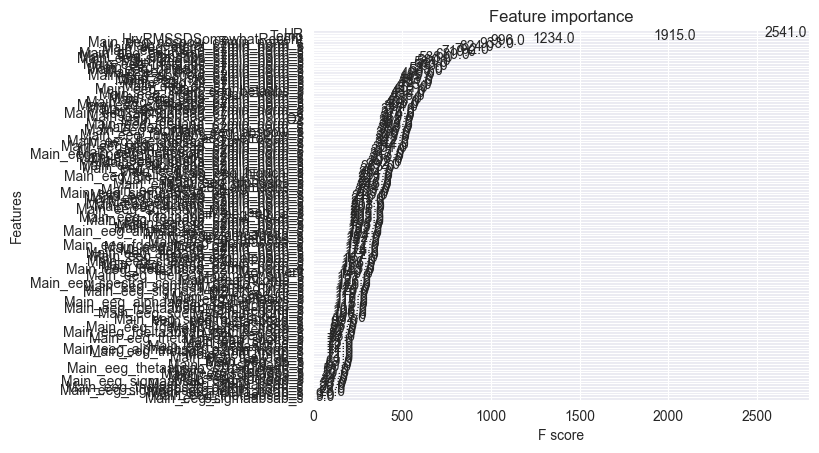

In [31]:
xgb.plot_importance(bm.model)

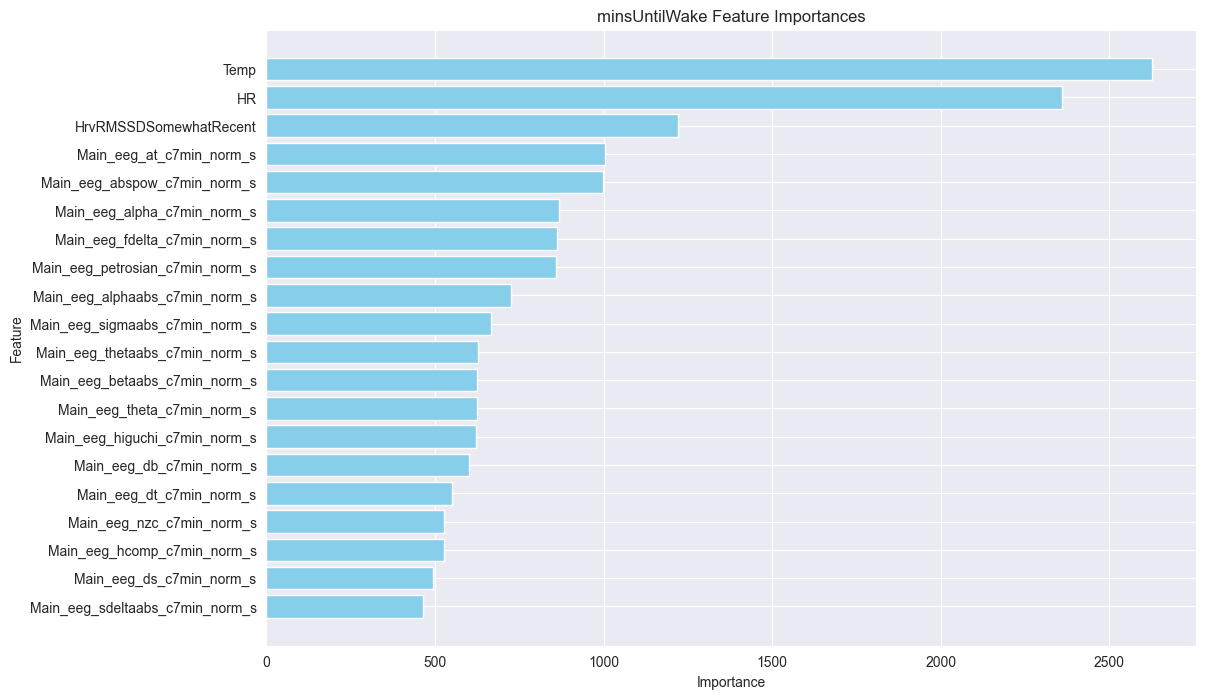

In [14]:
import models.util.importances as importances
from importlib import reload
reload(importances)
    
for md in modelsAndData:
    imp = importances.xgboost_importances(md)[0:20]
    importances.plot_importances(imp, md.name)

In [15]:
Ypetest_md = modelsAndData[0]

In [16]:
import seaborn as sns
sns.scatterplot(x='Main_eeg_perment_s', y=test_md.target_col, data=test_md.prepared_df)


NameError: name 'test_md' is not defined

In [75]:
test_md.prepared_df

,Confidence_x,F8-M1_Confidence_x,T4-M1_Confidence_x,O2-M1_Confidence_x,StageInt_x,Main_eeg_abspow_s,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alpha_c7min_norm_s,...,Fpz-M1_Confidence_x,F4-M1_Confidence_x,Fpz-M1_Confidence_y,F4-M1_Confidence_y,SettlingEventMatchedIdx,SettlingManualScore,SettlingV4ManualScore,TiredVsAlertManualScore,SettlingV4ScorePrediction,WillWakeWithin60Mins
2,0.999987,0.999951,0.999987,0.999412,0,0.673643,0.631520,1.210844,0.074071,-0.139941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,0.999875,0.999564,0.999875,0.997296,0,0.740908,0.620911,1.136667,0.091764,-0.137007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.999843,0.998763,0.999843,0.996956,0,0.417889,0.609999,0.669285,0.161176,-0.133391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,0.999532,0.998831,0.999532,0.997687,0,0.577379,0.604815,0.731069,0.068022,-0.130382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,0.999465,0.998943,0.999465,0.987641,0,0.811312,0.654045,0.744720,0.098874,-0.120942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.999282,NaN,NaN,NaN,0,0.279018,1.278017,2.111404,0.099304,-0.030497,...,0.999282,NaN,0.999282,NaN,NaN,NaN,NaN,NaN,1.0,False
1145,0.997849,NaN,NaN,NaN,0,1.149445,1.162454,1.264398,-0.015355,-0.004882,...,0.997849,NaN,0.997849,NaN,NaN,NaN,NaN,NaN,1.0,False
1146,0.997343,NaN,NaN,NaN,0,0.348046,1.017307,0.871481,0.121749,0.027155,...,0.997343,NaN,0.997343,NaN,NaN,NaN,NaN,NaN,1.0,False
1147,0.998733,NaN,NaN,NaN,0,0.595378,0.870215,0.761752,0.069582,0.060004,...,0.998733,NaN,0.998733,NaN,NaN,NaN,NaN,NaN,1.0,False


<Axes: xlabel='TimeToReadyToSleepMins', ylabel='Main_eeg_perm_s'>

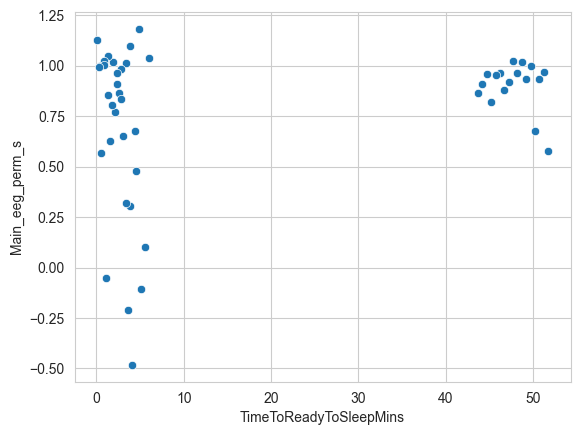

In [160]:
day1 =  test_md.prepared_df[0:48]
sns.scatterplot(y='Main_eeg_perm_s', x=target_cols[1], data=day1)


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').mean().reset_index()

    # Plot the average value for each integer version of x with a linear regression line
    sns.regplot(x='TimeToReadyToSleepMins_int', y=col_name, data=grouped, ax=ax, scatter_kws={'s': 10})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

KeyError: 'TimeToReadyToSleepMins'

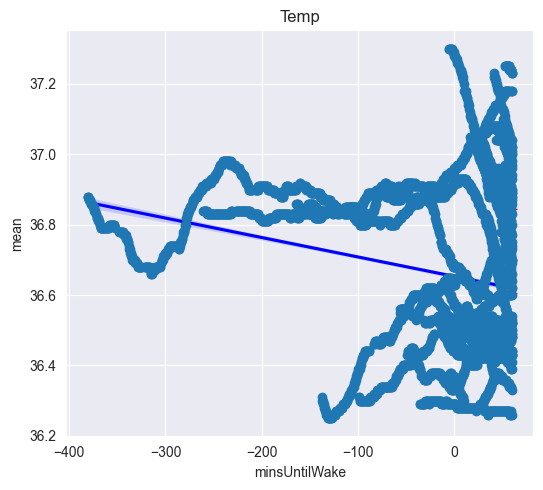

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time=60):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2 = df2[df2['minsUntilWake'] <= max_time]
    grouped = df2.groupby('minsUntilWake').agg({col_name: ['mean', 'std']}).reset_index()
    grouped.columns = ['minsUntilWake', 'mean', 'std']

    # Plot the average value for each integer version of x with error bars
    ax.errorbar(grouped['minsUntilWake'], grouped['mean'], yerr=grouped['std'], fmt='o', ecolor='r', capsize=5)
    sns.regplot(x='minsUntilWake', y='mean', data=grouped, ax=ax, scatter=False, line_kws={'color': 'blue'})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
# correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
# columns_to_plot = correlations.index
columns_to_plot = ['Temp']

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(merged, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

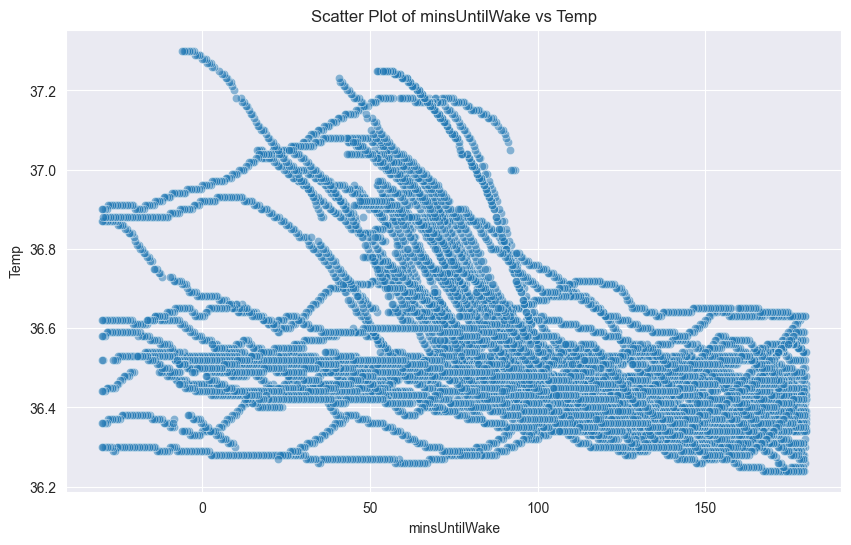

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for minsUntilWake <= 60
filtered_df = merged[(merged['minsUntilWake'] <= 180) & (merged['minsUntilWake'] >= -30)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=filtered_df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()

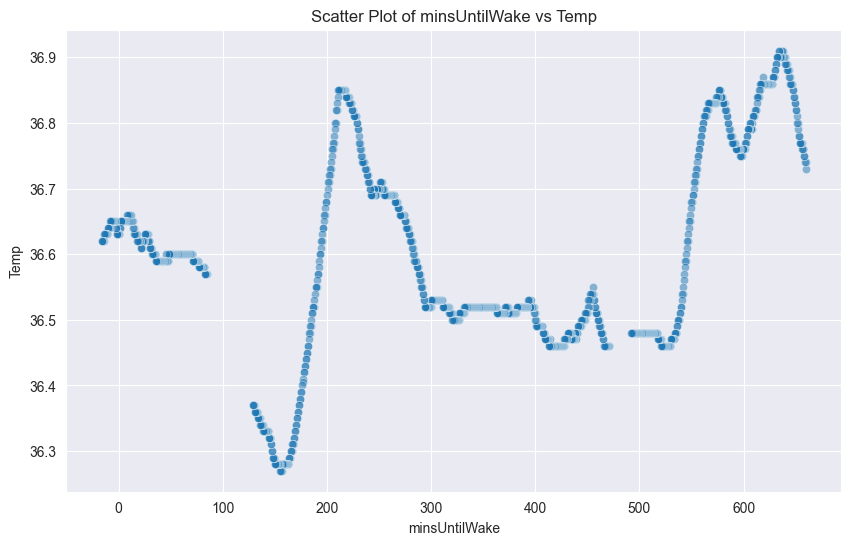

In [101]:
df = merged[merged['dayAndNightOf'] == '2024-12-05']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()
